In [1]:
#importing basic libs
import matplotlib.pyplot as plt
import math
import pandas as pd

#import libs for scraping
from bs4 import BeautifulSoup as bs
import requests
import re

#from pymongo import MongoClient

#import libs for diagnostics
import time
from IPython.display import clear_output

#importing libs for clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#import libs for cleaning and stemming of the descriptions
from nltk.corpus import stopwords
stop_words = set(stopwords.words("italian"))
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('italian')
import math

#importling libs for the wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


## Defining our Functions

In [2]:
def getDetails(url, i):
    #getting up beautifulsoup and requests so we can crawl the url passed to the function
    content = requests.get(url)
    soup = bs(content.text, 'html.parser')

    #Checking what class contains the information that we want to retrieve. 
    #At some point different classes are used in the web page so this step is necessary.
    classes = ["listing-item vetrina js-row-detail", "listing-item star js-row-detail","listing-item top js-row-detail", "listing-item premium js-row-detail"]
    for item in classes:
        if item in content.text:
            use_class = item
        
    #creating empty list to be filled with a list of details of all apartement listet on the current page
    detlist =[]
    
    for app in soup.find_all(class_=use_class):

        #creating empty list to fill with the details of the appartement in app
        dets =[]
        
        #Retrieving the link of the apartement thats contained in the class "titolo text-primary"
        #by searching for the first occurence of 'href'.
        link_class = app.find(class_="titolo text-primary")
        link = link_class.find('a', href=True)['href']
        
        #Skipping the listsings that are advertisments or something like it
        if link.startswith('/nuove_costruzioni/'):
            continue
            
        #appending the link to the list of details 
        dets.append(link)
        
        #Retrieving the price of the apartement. It is contained in the second item in the list that beautifulsoup
        price = app.find(class_="listing-features list-piped")
        #appending the price to the list of details
        dets.append(price.contents[1].text.strip().split(" ")[1])

        #getting the information on the other attributes of the appartement (e.g. bagni, piano )
        for details in app.find_all(class_="lif__data"):
            det = details.contents[0]
            dets.append(det.get_text().strip())
        
        #getting the description of the current listing and appending it to the list of details we want to scrape.
        #will only be executed if the listing provides all the information we need.
        if len(dets) == 6:
            desc = getDescription(link, i)
            if desc is None:
                continue
            else: 
                dets.append(desc)
            
        #appending the list of details for the current apartement to the list of the
        #details of the other appartement on the current page of the search result.
        #We don't add if there is some information missing that we are going to need.
        if len(dets) == 7:
            detlist.append(dets)
    
    return detlist

def getDescription(link, i):
    #setting timer so we dont get blocked. We only need it in this if statement as we are not getting the description
    #if some other information (e.g. bagni) is missing.
    time.sleep(2)
    #list with links we couldn't get the description from (diagnostic purposes)
    dead_desc= []

    desc_cont = requests.get(link)
    desc_soup = bs(desc_cont.text, 'html.parser')
    desc = desc_soup.find('div',attrs={'class':'col-xs-12 description-text text-compressed','role':'contentinfo','aria-expanded':'false'})
    if desc is not None:
        desc = desc.get_text()  
        desc=re.sub('\n',' ',desc)
        desc=re.sub('_',' ',desc)
        desc=re.sub('\t','',desc)
        print(i, data.shape[0], link, desc)
        return desc
    else: 
        dead_desc.append([i, link])
        return None
        

In [3]:
def dfToCsv(df,filename):
    df.to_csv(filename+'.csv', sep='\t')
    
def getVocabulary(vocabularyFile):
        with open(vocabularyFile, newline='') as file:
            reader = csv.reader(file, delimiter='\t')
            vocabulary = list(map(tuple, reader))
        file.close()
        return(vocabulary)

    
def saveVocabulary(vocabulary,fileName="output.csv"):
    with open(fileName,'wb') as vfile:
        for i in vocabulary.keys():
            vfile.write(str(i).encode())
            vfile.write(str('\t').encode())
            vfile.write(str(vocabulary[i]).encode())
            vfile.write('\n'.encode())
        vfile.close()

def cleanData(rawData, lang='italian'):
        tokenizer = RegexpTokenizer(r'\w+')
        stop_words = set(stopwords.words(lang))

        # get words lowercased
        t0 = rawData.lower()
        # remove puctuations
        t1 = tokenizer.tokenize(t0)

        # remove stop words
        t2 =[]
        t2 = [t1[i] for i in range(0,len(t1)) if t1[i] not in stop_words]

        # stemm words
        t3 = [stemmer.stem(t2[i]) for i in range(0, len(t2))]

        # remove nummbers and strings starting with numbers
        t4 = [t3[i] for i in range(0, len(t3)) if t3[i][0].isdigit()==False]

        return(t4)
    
def TermDictionaries(ColumnOfDerscriptions):
    Term_Id = {}
    Inv_Dict = {}
    num = 0
    for i in ColumnOfDerscriptions:
        app = cleanData(i, lang='italian')
        for w in set(app):
            if w not in Term_Id:
                Inv_Dict[len(Term_Id)] = [num]
                Term_Id[w]=len(Term_Id)        
            else:
                Inv_Dict[Term_Id.get(w)].append(num)
        num += 1
    return(Term_Id,Inv_Dict)

def Idf(word,Inv_Dict,Term_Id,Data):
    key = Term_Id[word]
    Idf = {}
    n = len(Data)
    Idf = math.log10(n/len(Inv_Dict[key]))
    return Idf

def Tf(word,ann):
    Tf = ann.count(word)/len(ann)
    return Tf        
        
#modified cleaning function for the word cloud
def cleanDataWc(rawData, lang='italian'):
        tokenizer = RegexpTokenizer(r'\w+')
        stop_words = set(stopwords.words(lang))

        # remove puctuations
        t1 = tokenizer.tokenize(rawData)

        # remove stop words
        t2 =[]
        t2 = [t1[i] for i in range(0,len(t1)) if t1[i] not in stop_words]


        # remove nummbers and strings starting with numbers
        t3 = [t2[i] for i in range(0, len(t2)) if t2[i][0].isdigit()==False]

        return(t3)

## Scraping our data
We did it all at once so we have a consistent dataset for both matrices.

In [21]:
#data = pd.DataFrame()
i = 521 
#call function with the next page of search results as long as the dataframe 
#does not contain 10000 rows (+1 because of the header of the dataframe)
while data.shape[0] <= 10200:
    clear_output()
    #setting up the urls to be crawled by our function, starting from page one (as i is defined as 1 befor executing)
    url = "https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="+str(i)
    
    #appending the nested list with the lists of details for every apartement to the dataframe
    appendlist = getDetails(url, i)
    
    #checking if the list returnd by our function is not empty.
    if len(appendlist) !=0:
        data = data.append(appendlist)
        
    clear_output()
    #increasing i by one so the next page of search results will be crawled
    i+=1
    #setting  timer so our requests won't get blocked
    data.to_csv('df.csv', sep='\t')
    time.sleep(2)




Checking the size of our dataset. 

In [134]:
data.shape[0]

10104

Loading the saved csv file with our data

In [148]:
data = pd.read_csv('df.csv', sep='\t')

In [149]:
data = data.drop_duplicates(subset=None, keep='first')
data = data.dropna()

In [ ]:
data['1'] = data['1'].replace({'\.':'','\€':''}, regex = True)
data['1'] = data['1'][data['1'] != 'SU']
data['1'] = pd.to_numeric(data['1'])
data['2'] = data['2'].map({'1': 1, '2':2, '3':3, '4': 4, '5':5, '5+':6})
data['3'] = pd.to_numeric(data['3'])
data['4'] = data['4'].map({'1': 1, '2':2, '3':3, '3+': 4})
data['5'] = data['5'].map({'1': 1, '2':2, '3':3, '4': 4, '5':5, '6':6, '7':7, '8':8, '9':9, '10':10, '11+':11, 'T': 0, 'S': -1, 'A': 12, 'R': 0.5})    

In [151]:
data = data.reset_index(drop=True)

checking the size of our cleaned dataset

In [152]:
data.shape[0]

10055

saving our cleaned dataset

In [153]:
dfToCsv(data, 'df-clean')

retrieving only the values from our cleand dataset we need for the first matrix

In [154]:
matrix1 = data[['1', '2', '3', '4', '5']].copy()

In [155]:
dfToCsv(matrix1, 'matrix1')

converting the dataframe of values to an array that we can use for the clustering

In [156]:
#convert to array
matrix1_array = matrix1.values

In [157]:
print(matrix1_array.dtype)
print(matrix1_array)

float64
[[2.25e+05 2.00e+00 5.00e+01 1.00e+00 1.00e+00]
 [3.75e+05 3.00e+00 1.20e+02 1.00e+00 3.00e+00]
 [6.80e+04 2.00e+00 2.00e+01 1.00e+00 0.00e+00]
 ...
 [2.89e+05 2.00e+00 6.80e+01 1.00e+00 6.00e+00]
 [1.89e+05 3.00e+00 1.27e+02 1.00e+00 3.00e+00]
 [6.25e+05 5.00e+00 1.45e+02 2.00e+00 1.00e+00]]


Creating dictionaries for term Id and the inverse index

In [56]:
Term_Id,Inv_Dict = TermDictionaries(data.loc[:,'6'])

In [57]:
saveVocabulary(Term_Id,fileName='Term_Id.csv')

In [58]:
Term_Id

{'noc': 0,
 'port': 1,
 'elettron': 2,
 'ampi': 3,
 'vetr': 4,
 'sab': 5,
 'preg': 6,
 'pannell': 7,
 'riscald': 8,
 'grees': 9,
 'serr': 10,
 'cam': 11,
 'cottur': 12,
 'compless': 13,
 'venrd': 14,
 'stanz': 15,
 'fotovolt': 16,
 'pres': 17,
 'term': 18,
 'videocitof': 19,
 'termoautonom': 20,
 'parquet': 21,
 'residenzial': 22,
 'chius': 23,
 'infiss': 24,
 'balcon': 25,
 'tutt': 26,
 'marted': 27,
 'pav': 28,
 'lett': 29,
 'eur': 30,
 'ari': 31,
 'compost': 32,
 'chiusur': 33,
 'centralizz': 34,
 'luned': 35,
 'grat': 36,
 'impiant': 37,
 'soggiorn': 38,
 'orar': 39,
 'domen': 40,
 'rifinitissim': 41,
 'rifinitur': 42,
 'camer': 43,
 'blind': 44,
 'antenn': 45,
 'condizion': 46,
 'mercoled': 47,
 'elettr': 48,
 'antifurt': 49,
 'solar': 50,
 'bilocal': 51,
 'bagn': 52,
 'eleg': 53,
 'telefon': 54,
 'rilev': 55,
 'salon': 56,
 'angol': 57,
 'gioved': 58,
 'gas': 59,
 'acust': 60,
 'satellit': 61,
 'forn': 62,
 'caldai': 63,
 'isol': 64,
 'papill': 65,
 'legn': 66,
 'possibil': 67,
 

In [59]:
saveVocabulary(Inv_Dict,fileName='Inv_Dict.csv')

In [60]:
Inv_Dict

{0: [0],
 1: [0, 3, 9, 11],
 2: [0],
 3: [0, 2, 3, 4, 5, 9, 10, 12, 13, 14, 15, 17],
 4: [0, 9],
 5: [0],
 6: [0, 9],
 7: [0, 3],
 8: [0, 4, 11, 14, 19],
 9: [0],
 10: [0],
 11: [0, 1, 3, 5, 6, 7, 8, 10, 12, 13, 14, 15, 17, 19],
 12: [0, 4, 10],
 13: [0],
 14: [0],
 15: [0],
 16: [0, 4],
 17: [0],
 18: [0],
 19: [0, 4, 19],
 20: [0],
 21: [0, 9, 19],
 22: [0, 6],
 23: [0],
 24: [0, 4, 9, 13],
 25: [0, 4, 7, 14, 17],
 26: [0, 2, 5, 11, 13, 15],
 27: [0],
 28: [0, 4, 9, 13],
 29: [0, 3, 9, 12, 17],
 30: [0, 3, 7],
 31: [0, 9, 11, 13],
 32: [0, 2, 3, 4, 5, 6, 11, 15, 17],
 33: [0],
 34: [0, 4, 14, 19],
 35: [0],
 36: [0],
 37: [0, 4, 9, 14, 19],
 38: [0, 8, 16],
 39: [0],
 40: [0],
 41: [0],
 42: [0, 4],
 43: [0, 1, 3, 4, 5, 9, 11, 13, 16, 17, 18],
 44: [0, 4, 9, 13, 19],
 45: [0],
 46: [0, 9, 11, 13, 14],
 47: [0],
 48: [0, 9],
 49: [0],
 50: [0],
 51: [0],
 52: [0, 3, 4, 6, 9, 10, 12, 13, 14, 16, 17, 18],
 53: [0, 5, 9, 12, 17, 19],
 54: [0],
 55: [0, 4],
 56: [0, 1, 3, 4, 5, 6, 7, 8, 9

Creating the matrix that contains the TfIdf

In [ ]:
matrix = pd.DataFrame()
num = 0
col = [*Term_Id.values()]
for i in data.loc[:,'6']:
    app = cleanData(i, lang='italian')        score = []
    for word in Term_Id.keys():
        TfIdf = Tf(word,app)*Idf(word,Inv_Dict,Term_Id,data)
        score.append(TfIdf)
    interest = pd.DataFrame([score],columns=col)
    matrix = pd.concat([matrix,interest])
    num += 1
matrix = matrix.reset_index(drop=True)

saving the tfidf matrix to file

In [ ]:
dfToCsv(matrix, TfIdf)

Finding the elbow for the clustering for matrix 1

In [174]:
Sum_of_squared_distances = []
K = range(1,31)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(matrix1)
    Sum_of_squared_distances.append(km.inertia_)

In [175]:
len(Sum_of_squared_distances)

30

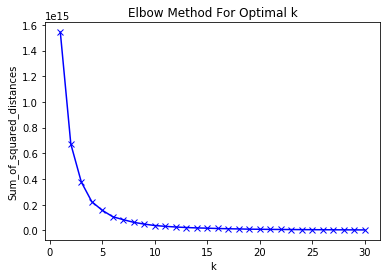

In [176]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Clustering the first matrix

In [183]:
import numpy as np
kmeans = KMeans(n_clusters=4,init='k-means++', random_state=0).fit(matrix1_array)
kmeansl1 = kmeans.labels_


In [ ]:
#appending matching cluster to dataframe

In [184]:
data['mat1_c'] = kmeansl1


In [ ]:
df1 = df1.assign(mat1_c=p.Series(np.random.randn(sLength)).values)
df['mat1_c'] = kmeansl1


Reading the file of the TfIdf matrix and converting it to an array

In [163]:
matrix2 = pd.read_csv('TfIdf.csv', sep='\t')

In [164]:
matrix2.shape

(10055, 14505)

In [166]:
matrix2 = matrix2.iloc[:,1:matrix2.shape[1]]

In [168]:
#convert to array
matrix2_array = matrix2.values

In [169]:
matrix2_array

array([[0.05469329, 0.01058448, 0.00381949, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0033537 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.01385605, 0.00500006, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00088998, ..., 0.01295269, 0.01295269,
        0.01295269]])

In [170]:
len(matrix2_array)

10055

In [191]:
cluster1={'0':[],'1':[],'2':[],'3':[]}
for i in range(matrix1.shape[0]):
    cluster1[str(kmeansl1[i])].append(i)

In [192]:
cluster1

{'0': [3,
  7,
  9,
  12,
  14,
  20,
  21,
  22,
  25,
  27,
  30,
  31,
  39,
  43,
  44,
  47,
  48,
  49,
  54,
  57,
  58,
  68,
  69,
  71,
  73,
  77,
  78,
  79,
  80,
  84,
  85,
  87,
  88,
  93,
  95,
  96,
  108,
  110,
  111,
  112,
  113,
  115,
  118,
  124,
  130,
  131,
  139,
  141,
  145,
  148,
  150,
  152,
  156,
  157,
  160,
  161,
  162,
  163,
  164,
  165,
  167,
  168,
  170,
  172,
  173,
  174,
  179,
  180,
  183,
  184,
  185,
  188,
  191,
  193,
  194,
  195,
  197,
  202,
  205,
  207,
  208,
  209,
  218,
  219,
  220,
  222,
  224,
  225,
  228,
  231,
  232,
  233,
  235,
  238,
  240,
  241,
  242,
  243,
  257,
  269,
  272,
  276,
  278,
  283,
  286,
  287,
  290,
  291,
  293,
  295,
  298,
  301,
  302,
  304,
  305,
  310,
  315,
  318,
  327,
  331,
  339,
  345,
  346,
  349,
  351,
  352,
  353,
  354,
  356,
  357,
  362,
  364,
  365,
  367,
  369,
  372,
  373,
  379,
  385,
  388,
  389,
  392,
  394,
  395,
  411,
  412,
  419,
  420

## Calculation kmeans for matrix 2
We looked if the elbow for the clustering of the second matrix is inside 30 clusters, because a larger number of clusters would result in very sparse clusters. 

In [178]:
Sum_of_squared_distances2 = []
K = range(1,31)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(matrix2_array)
    Sum_of_squared_distances2.append(km.inertia_)


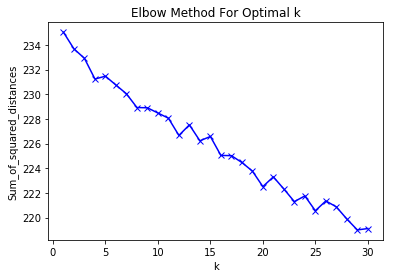

In [179]:
plt.plot(K, Sum_of_squared_distances2, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

clustering the second matrix to 4 clusters as we couldn't find a elbow and we have a a small jump up at 5.

In [180]:
import numpy as np
kmeans = KMeans(n_clusters=4,init='k-means++', random_state=0).fit(matrix2_array)
kmeansl2 = kmeans.labels_


In [194]:
data['mat2_c'] = kmeansl2
dfToCsv(data, 'df_clean_clust')

to be edited

In [189]:
cluster2={'0':[],'1':[],'2':[],'3':[]}
for i in range(matrix2.shape[0]):
    cluster2[str(kmeansl2[i])].append(i)

In [190]:
cluster2

{'0': [4,
  12,
  13,
  14,
  17,
  19,
  22,
  25,
  31,
  32,
  40,
  44,
  46,
  50,
  53,
  55,
  59,
  66,
  68,
  73,
  78,
  79,
  97,
  98,
  99,
  100,
  102,
  108,
  109,
  111,
  114,
  117,
  118,
  119,
  120,
  123,
  124,
  128,
  132,
  135,
  139,
  141,
  144,
  158,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  170,
  172,
  173,
  174,
  176,
  177,
  178,
  179,
  180,
  181,
  183,
  184,
  186,
  188,
  190,
  191,
  192,
  193,
  197,
  198,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  211,
  213,
  215,
  217,
  218,
  219,
  220,
  222,
  223,
  225,
  231,
  233,
  234,
  236,
  237,
  240,
  241,
  242,
  244,
  245,
  247,
  267,
  274,
  275,
  276,
  277,
  280,
  281,
  283,
  285,
  286,
  287,
  288,
  290,
  291,
  293,
  295,
  297,
  300,
  331,
  337,
  339,
  384,
  389,
  393,
  396,
  420,
  422,
  424,
  428,
  433,
  449,
  496,
  531,
  532,
  533,
  534,
  535,
  536,
  537,
  550,
  556,
  564,

calculating jaccard similarity

In [195]:
def compute_jaccard(user1_vals, user2_vals):
    user1_vals = set(user1_vals)
    user2_vals = set(user2_vals)
    intersection = user1_vals.intersection(user2_vals)
    union = user1_vals.union(user2_vals)
    jaccard = len(intersection)/float(len(union))
    return jaccard

In [196]:
Jaccard_sim = pd.DataFrame()
col = ["cluster 1st matrix", "cluster 2nd matrix", "Jaccard"]
for i in range(len(cluster1.keys())):
    for j in range(len(cluster2.keys())):
        x=compute_jaccard(cluster1[str(i)], cluster2[str(j)])
        score=[str(i), str(j), x]
        interest = pd.DataFrame([score],columns=col)
        Jaccard_sim = pd.concat([Jaccard_sim,interest])

Jaccard_sim= Jaccard_sim.reset_index(drop=True)

In [197]:
Jaccard_sim

,cluster 1st matrix,cluster 2nd matrix,Jaccard
0,0,0,0.087109
1,0,1,0.092284
2,0,2,0.016888
3,0,3,0.221332
4,1,0,0.094181
5,1,1,0.200558
6,1,2,0.016569
7,1,3,0.517799
8,2,0,0.008197
9,2,1,0.000510


 3-most similar couples of clusters

In [198]:
Jaccard_sim.sort_values("Jaccard", ascending=False)[:3]

,cluster 1st matrix,cluster 2nd matrix,Jaccard
7,1,3,0.517799
3,0,3,0.221332
5,1,1,0.200558


Creating the word clouds

In [4]:
data = pd.read_csv('df_clean_clust.csv', sep='\t')
data

,Unnamed: 0,Unnamed: 0.1,0,1,2,3,4,5,6,mat1_c,mat2_c
0,0,0,https://www.immobiliare.it/53131931-Vendita-Bi...,225000.0,2,50.0,1,1.0,PAPILLO EUR ...,1,3
1,1,1,https://www.immobiliare.it/68172417-Vendita-Tr...,375000.0,3,120.0,1,3.0,"Pigneto, App...",1,2
2,2,2,https://www.immobiliare.it/67991129-Vendita-Lo...,68000.0,2,20.0,1,0.0,Rif: 18066 -...,1,1
3,3,3,https://www.immobiliare.it/70177030-Vendita-Ap...,450000.0,5,150.0,2,3.0,Zona EUR - V...,0,3
4,4,4,https://www.immobiliare.it/67401927-Vendita-Tr...,315000.0,3,92.0,2,5.0,Fino al 31/1...,1,0
5,5,5,https://www.immobiliare.it/61128410-Vendita-At...,269000.0,4,131.0,2,12.0,Rif: 17029 -...,1,1
6,6,6,https://www.immobiliare.it/70089532-Vendita-Ap...,1599000.0,6,270.0,4,0.5,In palazzina...,3,3
7,7,7,https://www.immobiliare.it/69826494-Vendita-Ap...,579000.0,5,160.0,2,2.0,"Eur, Apparta...",0,2
8,8,8,https://www.immobiliare.it/68632829-Vendita-Tr...,385000.0,3,100.0,3,2.0,San Giovanni...,1,2
9,9,9,https://www.immobiliare.it/64762998-Vendita-At...,940000.0,6,200.0,3,12.0,Nella tranqu...,0,3


In [7]:
text_c1 = ''
text_c2 = ''
text_c3 = ''

for index, row in data.iterrows():
    if data.mat1_c[index] == 1 and data.mat2_c[index] == 3 :
        text_c1 = text_c1 + data['6'][index]
    if data.mat1_c[index] == 0 and data.mat2_c[index] == 3:
        text_c2 = text_c2 + data['6'][index]
    if data.mat1_c[index] == 1 and data.mat2_c[index] == 1:
        text_c3 = text_c3 + data['6'][index]

In [9]:
text_c1 = cleanDataWc(text_c1)
text_c2 = cleanDataWc(text_c2)
text_c3 = cleanDataWc(text_c3)

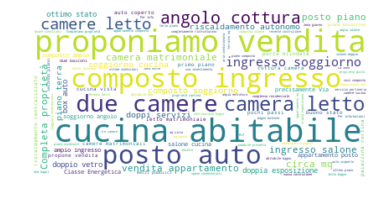

In [11]:
wordcloud1 = WordCloud(background_color="white").generate(' '.join(text_c1))

plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

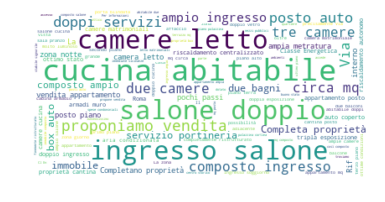

In [12]:
wordcloud2 = WordCloud(background_color="white").generate(' '.join(text_c2))

plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

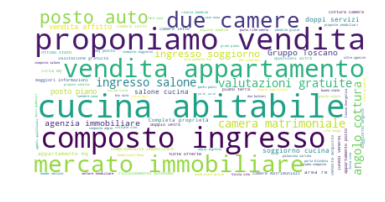

In [13]:
wordcloud3 = WordCloud(background_color="white").generate(' '.join(text_c3))

plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()